# Linear regression estimate quality (bivariate with Gaussian noise)

Up to now, the regression models with [1](LinearRegressionUnivariate.ipynb) or [2](LinearRegressionBivariate.ipynb) features were based on a infinite length dataset. As a consequence, all estimates were (almost) perfect.

In a given "real life" application, the dataset might be limited for many reasons like:
- the data collect is slow (low frequency) and it has started recently
- the phenomena to explain is not that stable (stationary), and quasi stationarity time interval corresponds to a small dataset

Data analysis and modeling is possible still, but then we must take into account for variability

### Learning goals
- Learn about the Gaussian linear model
- Show the impact of reduced length dataset on estimate quality (bias, variance)
- __Theory__ and experiments using small length training datasets
- __Confidence intervals__ on the estimates 

### References 

- Lectures notes on ordinary least squares, Telecom Paris, François Portier and Anne Sabourin (Unpublished)
- High-Dimensional Statistics, chapter 2 : Fixed Design linear regression, [MIT 18.S997 2015](https://ocw.mit.edu/courses/mathematics/18-s997-high-dimensional-statistics-spring-2015/lecture-notes/MIT18_S997S15_Chapter2.pdf)


### Model

We will use a linear model with Gaussian noise, also called _Fixed Design_ $f_1(x) = 0.5 x_0 - 0.7 x_1 + 0.35 + \epsilon$

With : 
- $x_0 \in [0, 0.5], x_1 \in [-0.5, 0.5]$ the two features (co-variables) 
- $\epsilon \sim \mathcal{N}(0, v)$ a Gaussian distributed unknown

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import normalize as skNormalize
import pandas as pd
import math
import scipy.stats as stats
import seaborn as sns
from heat_map import plot_heat_map

## Helpers

In [2]:
def plotHistParams(x, label, ax, span, nBins = 100, pdfRefX=None, pdfRefY=None):
    """Plot histogram x, compute """
    ax.hist(x, bins=nBins, density=True, range=span, label='histogram')
    mu = np.mean(x)
    x_c = x - mu
    ax.set_title('%s\n$\mu$=%.3f, $\sigma^2$=%.3f' % (label, mu, np.dot(x_c,x_c) / len(x)))
    if not pdfRefX is None:
        ax.plot(pdfRefX, pdfRefY, label='ref')
        ax.legend()
        
def plotToRef(x, y, ref, ax, title, xLabel=None, yErr=None):
    """ Plot y and a reference (or target) value"""
    if yErr is None:
        ax.plot(x, y)
    else:
        ax.errorbar(x, y, yerr=yErr, ecolor='red', capsize=3.0)
    if xLabel:
        ax.set_xlabel(xLabel)
    ax.plot(x, np.ones((len(x)))*ref, alpha=0.5, color='orange')
    ax.set_title(title)
    ax.grid()

## Model

In [3]:
nFeatures = 2
bLin = 0.35
wLin = [0.5, -0.7]
sigmaLin = 0.5
def generateBatchLinear(n, sigma=sigmaLin):
    #
    xMin = np.array([0, -0.5])
    xMax = np.array([0.5, 0.5])
    #
    x = np.random.uniform(xMin, xMax, (n, 2))
    yClean = np.dot(x, wLin) + bLin
    return x, yClean, yClean + np.random.normal(0, sigma, n)

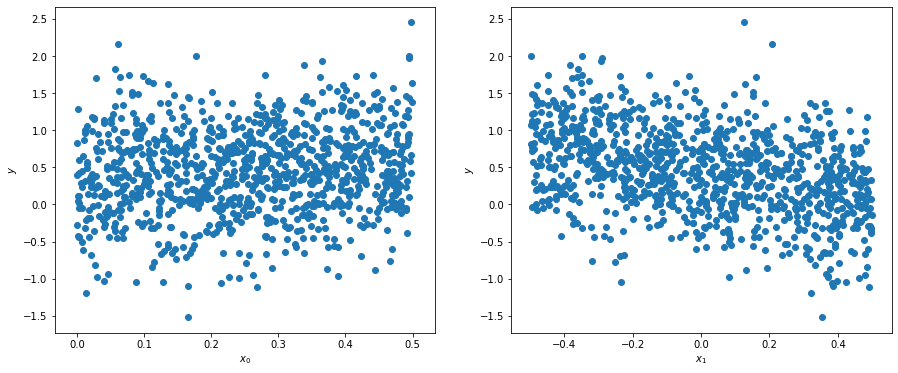

In [4]:
x_1000, yClean_1000, y_1000 = generateBatchLinear(1000, sigmaLin)
fix, ax = plt.subplots(1,2, figsize=(15, 6))
ax[0].scatter(x_1000[:, 0], y_1000)
ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('$y$');
ax[1].scatter(x_1000[:, 1], y_1000)
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$y$');

In the case we have no a priori knowledge but the model to apply (Gaussian), there are five quantities to evaluate :
- $\hat{w}_0, \hat{w}_1$ the weights to apply to the features
- $\hat{b}$ the intercept
- the Gaussian noise with the mean $\hat{\mu}$, and variance (power) $\hat{\sigma}^2$  

## Closed form linear regression

As explained in more details in previous notebook ([HTML](LinearRegressionBivariate.html) / [Jupyter](LinearRegressionBivariate.ipynb), the linear regression estimates are computed in closed form by **minimizing the Euclidian norm** $\lVert X_m \Theta - Y \rVert_2^2$ with:
- $\Theta = 
\begin{bmatrix}
b \\
w_0 \\
w_1 \end{bmatrix} $
- $X_m = 
\begin{bmatrix}
\mathbb{1}_n & X \\
\end{bmatrix}$

Then :  $ Y = X_m \Theta + \epsilon $

Leading to the closed form computation of the linear regression, assuming the matrix is invertible (or at least pseudo invertible) : 
$$\hat{\Theta} = (X_m^T X_m)^{-1} X_m^T Y$$


In [5]:
def xWithIntercept(x):
    """ Add a column of ones in order to compute the intercept along with coefficients related to X"""
    return np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)

x_m_1000 = xWithIntercept(x_1000)

def linearRegression(x, y):
    xTxInv = np.linalg.inv(np.matmul(x.T, x))
    return np.matmul(xTxInv, np.matmul(x.T, y))

thetaEst0 = linearRegression(x_m_1000, yClean_1000)
print("Estimation on clean y : Intercept=%.4f, coefficients=%s" % (thetaEst0[0], thetaEst0[1:]))

thetaEst_1000 = linearRegression(x_m_1000, y_1000)
print("Estimation on noisy y : Intercept=%.4f, coefficients=%s" % (thetaEst_1000[0], thetaEst_1000[1:]))

Estimation on clean y : Intercept=0.3500, coefficients=[ 0.5 -0.7]
Estimation on noisy y : Intercept=0.3286, coefficients=[ 0.50607512 -0.76514971]


## Noise estimation

The noise mean is simply computed as the mean of $Y - X_m \Theta$. It is expected to be 0 in our case.

Given a noise mean equal to 0, the **unbiased noise variance** estimation is then : 
$$ \hat{\sigma}^2 = \frac{1}{n-p-1} \Vert Y - X_m \hat{\Theta} \Vert_2^2$$

With : 
- $n$ the number of samples in our set
- $p$ the rank of the matrix $X^TX$, equal to 2 in our example
- $I_n$ the identity matrix with n rows and n columns

In [6]:
def noiseEstimation(yEst, y, p):
    """ Unbiased noise mean and variance estimation """
    epsilonEst = y - yEst
    mu = np.mean(epsilonEst)
    epsilonEst_c = epsilonEst - mu
    var = 1 / (len(y) - p - 1) * np.dot(epsilonEst_c, epsilonEst_c)
    return mu, var

noiseMu_1000, noiseVar_1000 = noiseEstimation(np.matmul(x_m_1000, thetaEst_1000), y_1000, nFeatures)
print('Estimated noise mean=%.2e and std deviation=%.4f' % (noiseMu_1000, math.sqrt(noiseVar_1000)))

Estimated noise mean=-3.04e-16 and std deviation=0.5271


### Other important theorerical results on the Gaussian linear model

Given $\hat{\Theta_{n,k}}$ the component $k$ of the estimate of $\Theta$ on $n$ samples, and $\Theta_k$ actual value of this component : 

- Lemma 1: $\left(\hat{\Theta_n} - \Theta \right) \sim \mathcal{N}\left( 0, (X^T X)^{-1} \sigma^2 \right)$
    - i.e. variations on the estimated components of $\Theta$ are Gaussian distributed


- Lemma 2: $\frac{\hat{\sigma_n}^2(n-p-1)}{\sigma^2} \sim  \chi^2(n-p-1)$
    - $\chi^2(n-p-1)$ is a Chi-2 law with n-p-1 degrees of freedom


- Lemma 3: $\sqrt{\frac{n}{\hat{\sigma_n}^2 S_{n,k}}} (\hat{\Theta_{n,k}} - \Theta_k) \sim \mathcal{T}_{n-p-1}$ 
    - $\mathcal{T}_{n-p-1}$ is the Student law with (n-p-1) degrees of freedom
    - $S_{n,k} = n (X^TX)^{-1}_{k,k}$ (select element k,k of the Gram matrix)

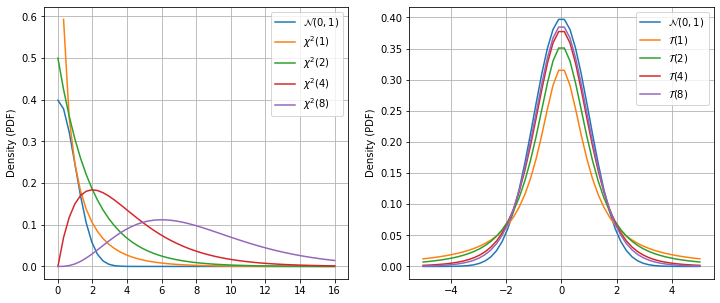

In [7]:
xx = np.linspace(0, 16)
fig,ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(xx, stats.norm.pdf(xx))
ax[0].plot(xx, stats.chi2(1).pdf(xx))
ax[0].plot(xx, stats.chi2(2).pdf(xx))
ax[0].plot(xx, stats.chi2(4).pdf(xx))
ax[0].plot(xx, stats.chi2(8).pdf(xx))
ax[0].legend(('$\mathcal{N}(0,1)$', '$\chi^2(1)$', '$\chi^2(2)$', '$\chi^2(4)$', '$\chi^2(8)$'))
ax[0].set_ylabel('Density (PDF)')
ax[0].grid()
xx = np.linspace(-5, 5)
ax[1].plot(xx, stats.norm.pdf(xx))
ax[1].plot(xx, stats.t(1).pdf(xx))
ax[1].plot(xx, stats.t(2).pdf(xx))
ax[1].plot(xx, stats.t(5).pdf(xx))
ax[1].plot(xx, stats.t(8).pdf(xx))
ax[1].legend(('$\mathcal{N}(0,1)$', '$\mathcal{T}(1)$', '$\mathcal{T}(2)$', '$\mathcal{T}(4)$', '$\mathcal{T}(8)$'))
ax[1].set_ylabel('Density (PDF)')
ax[1].grid()

As shown on right hand figure above, the Student law $\mathcal(T)$ quickly converges to the Gaussian law. 

Let's study in the following what is happening when the number of samples is much closer to the number of features.

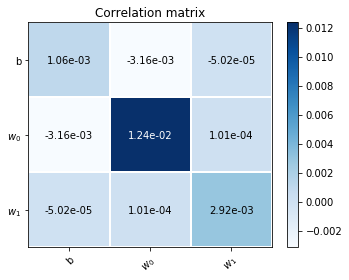

In [8]:
def weightCovariance(x, sigma):
    """ Compute weight covariance as per Lemma 1"""
    return np.linalg.inv(np.matmul(x.T, x)) * sigma**2

wCovTheo_1000 = weightCovariance(x_m_1000, sigmaLin) 
plot_heat_map(wCovTheo_1000, ('b','$w_0$', '$w_1$'), title='Correlation matrix', fmt='.2e');

## Sweep over dataset length

In a first move, let's sweep over the length of the data set from 5 to 10000 items and estimate the linear regression and the noise parameters.

Note : the minimum value of n is:  $min_{n \in \mathbb{N}} (n-p-1 > 0) = 4$

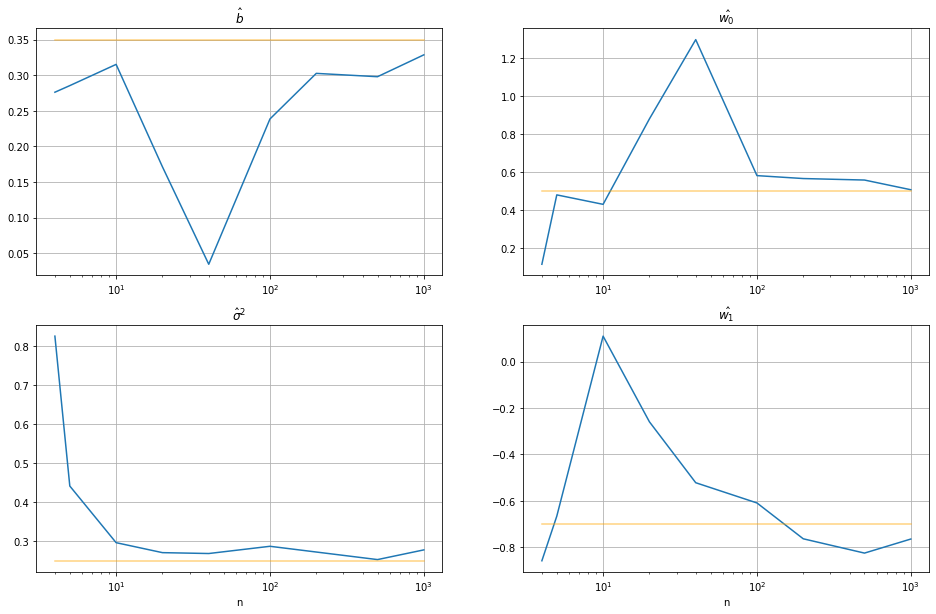

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10), subplot_kw={'xscale':'log'})

regressions = []
for n in [4, 5, 10, 20, 40, 100, 200, 500, 1000]:
    x_m_n = x_m_1000[:n]
    y_n = y_1000[:n]
    thetaEst = linearRegression(x_m_n, y_n)
    noiseMu, noiseVar = noiseEstimation(np.matmul(x_m_n, thetaEst), y_n, nFeatures)
    regressions.append([n, thetaEst[0], thetaEst[1], thetaEst[2], noiseMu, noiseVar])

dfSweepN = pd.DataFrame(regressions, columns=('n', 'b', 'w0','w1', 'noise mean', 'noise var'))
plotToRef(dfSweepN['n'], dfSweepN['b'], bLin, ax[0,0], '$\hat{b}$')
plotToRef(dfSweepN['n'], dfSweepN['noise var'], sigmaLin**2, ax[1,0], '$\hat{\sigma}^2$', xLabel='n')
plotToRef(dfSweepN['n'], dfSweepN['w0'], wLin[0], ax[0,1], '$\hat{w_0}$')
plotToRef(dfSweepN['n'], dfSweepN['w1'], wLin[1], ax[1,1], '$\hat{w_1}$', xLabel='n');

## Distributions with n = 5, fixed design

In this set of experiments, noise samples are drawn at each experiment. The $x_i$ are known and fixed.

Let's draw many experiences with n = 5 in order to plot the histograms of the estimators

In [10]:
regressions = []
n = 5
x_m_5 = x_m_1000[:n]
yClean_5 = yClean_1000[:n]
for l in range(50000):
    # Draw noise
    y_5 = yClean_5 + np.random.normal(0, sigmaLin, n)
    thetaEst = linearRegression(x_m_5, y_5)
    noiseMu, noiseVar = noiseEstimation(np.matmul(x_m_5, thetaEst), y_5, nFeatures)
    regressions.append([thetaEst[0], thetaEst[1], thetaEst[2], noiseMu, noiseVar])
    
df_5 = pd.DataFrame(regressions, columns=('b', 'w0','w1', 'noise mean', 'noise var'))

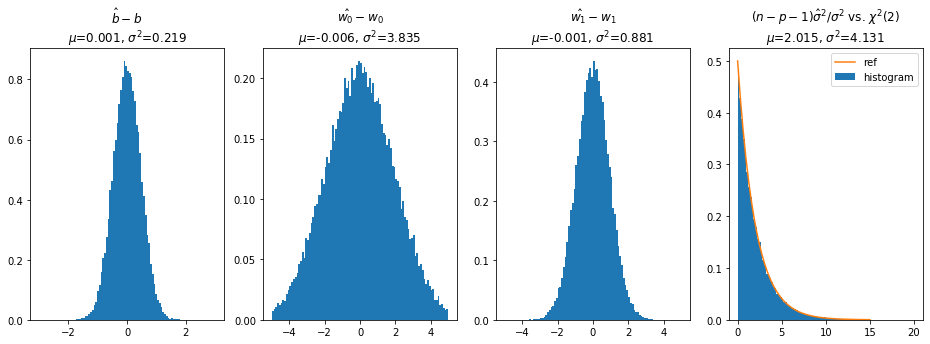

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
plotHistParams(df_5['b']  - bLin,    '$\hat{b} - b$',     ax[0], [-3, 3])
plotHistParams(df_5['w0'] - wLin[0], '$\hat{w_0} - w_0$', ax[1], [-5, 5])
plotHistParams(df_5['w1'] - wLin[1], '$\hat{w_1} - w_1$', ax[2], [-5, 5])

dFree = n - nFeatures - 1
xx = np.linspace(0,15)
plotHistParams(df_5['noise var'] * dFree / sigmaLin**2, '$(n-p-1)\hat{\sigma}^2 / \sigma^2$ vs. $\chi^2(2)$', 
                    ax[3], [0,20], pdfRefX=xx, pdfRefY=stats.chi2(dFree).pdf(xx))

On above graph, the regression intercept $b$ and weigths ($w_0, w_1$) look like gaussian distributed and the noise variance scaled by $\frac{n-p-1}{\sigma^2}$ with n=5, p=2, is matching the expected $\chi^2(2)$ (see Lemma 2)

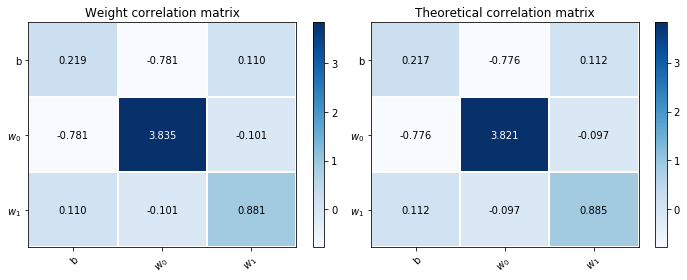

In [12]:
def autoCovariance(x, axis=0):
    x_c = x - np.mean(x, axis=0)
    return 1 / x.shape[axis] *  np.matmul(x_c.T, x_c)


# Covariance of the intercept and weights
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ThetaCov_5 = autoCovariance(df_5[['b', 'w0', 'w1']].values)
plot_heat_map(ThetaCov_5, ('b','$w_0$', '$w_1$'), title='Weight correlation matrix', ax=ax[0], fmt='.3f');

# Correlation matrix based on the design matrix (X^T X)
wCovTheo_5 = weightCovariance(x_m_5, sigmaLin)
plot_heat_map(wCovTheo_5, ('b','$w_0$', '$w_1$'), title='Theoretical correlation matrix', ax=ax[1], fmt='.3f');

Covariance matrices are matching !

Let's now verify the law involving only the $\hat{\Theta}$ and $\hat{\sigma}^2$ estimates, as per Lemma 3 :
- $J(\hat{\Theta_{n,k}}) = \sqrt{\frac{n}{\hat{\sigma_n}^2 S_{n,k}}} (\hat{\Theta_{n,k}} - \Theta_k) \sim \mathcal{T}_{n-p-1}$ 
    - $\mathcal{T}_{n-p-1}$ is the Student law with (n-p-1) degrees of freedom
    - $S_{n,k} = n (X^TX)^{-1}_{k,k}$ (select element k,k of the inverted Gram matrix)

In [13]:
n = 5
Theta_5Est = df_5[['b', 'w0', 'w1']].values
Theta_5Exp = np.array([bLin, wLin[0], wLin[1]])
estim = np.zeros((3, len(df_5)))
xTXInv_5 = n * np.linalg.inv(np.matmul(x_m_5.T, x_m_5))
nOverNoiseVarSqrt = np.sqrt(n / df_5['noise var'])
for k, theta in enumerate(Theta_5Est.T):
    Snk = xTXInv_5[k, k]
    estim[k] = math.sqrt(1/Snk)  * np.multiply(nOverNoiseVarSqrt, (theta - Theta_5Exp[k]))

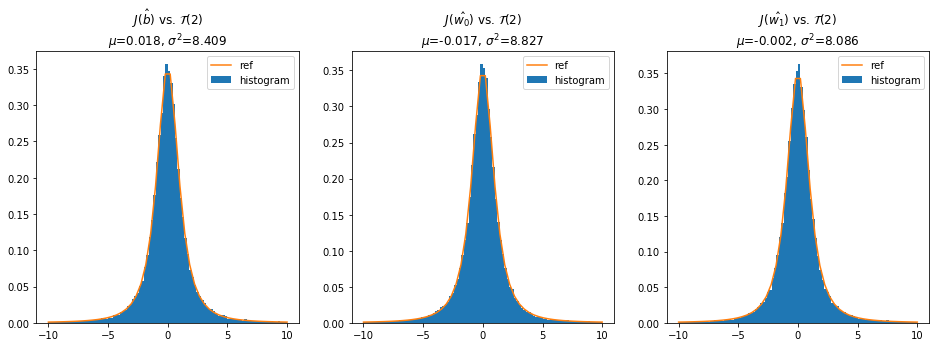

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
xx = np.linspace(-10, 10)
dFree = n - nFeatures - 1
pdfXx = stats.t(dFree).pdf(xx)
plotHistParams(estim[0], '$J(\hat{b})$ vs. $\mathcal{T}(2)$',   ax[0], [-10, 10], pdfRefX=xx, pdfRefY=pdfXx)
plotHistParams(estim[1], '$J(\hat{w_0})$ vs. $\mathcal{T}(2)$', ax[1], [-10, 10], pdfRefX=xx, pdfRefY=pdfXx)
plotHistParams(estim[2], '$J(\hat{w_1})$ vs. $\mathcal{T}(2)$', ax[2], [-10, 10], pdfRefX=xx, pdfRefY=pdfXx)

Theory is verified, we now have a closed form expression to compute the confidence interval on the estimates

## Confidence intervals

For this Gaussian linear model, for each coefficient, the confidence interval with level $\alpha$ is:
$$IC(\theta_k) = \left[ \hat{\theta_{n,k}} + \sqrt{\frac{\hat{\sigma_n}^2 S_{n,k}}{n}} q_{\frac{\alpha}{2}}, \hat{\theta_{n,k}} + \sqrt{\frac{\hat{\sigma_n}^2 S_{n,k}}{n}} q_{1-\frac{\alpha}{2}} \right]$$

With $q_{\frac{\alpha}{2}}$ and $q_{1-\frac{\alpha}{2}}$ the quantiles of the Student law $\mathcal{T}(n-p-1)$

We may now create a specific regression proceduer that is estimating the noise variance $\hat{\sigma}^2$ and provides confidence intervals for the coefficients:

In [15]:
def linearRegressionLinearGaussian(x, y, alpha):
    """ Compute linear regression coefficients and their confidence interval
            Assume that X is full rank
    """
    n = len(y)
    rank = x.shape[1] # = p + 1
    # Design matrix
    xTxInv = np.linalg.inv(np.matmul(x.T, x))
    # Regression coefficients
    thetas = np.matmul(xTxInv, np.matmul(x.T, y))
    # Predictions
    yEst = np.matmul(x, thetas)
    # Noise variance
    epsilonEst = y - yEst
    noiseMu = np.mean(epsilonEst) # for verification, but assumed 0
    epsilonEst_c = epsilonEst - noiseMu
    noiseVar = 1 / (n - rank) * np.dot(epsilonEst_c, epsilonEst_c)
    # Student quantile
    qAlpha = stats.t(n - rank).ppf(1 - alpha/2)
    # Confidence intervals
    xTxInvDiag = np.diagonal(xTxInv)
    confidence = np.sqrt(noiseVar * xTxInvDiag) * qAlpha
    return thetas, confidence, noiseVar

alpha = 0.1
thetas, confidence, noiseVar = linearRegressionLinearGaussian(x_m_5, y_5, alpha)
print('Coefficients =', thetas)
print('Confidence intervals @ %.0f%% :\n' % ((1-alpha)*100), 
      np.vstack((thetas - confidence, thetas + confidence)).T)
print('Noise variance estimate = %.3f' % noiseVar)

Coefficients = [ 1.00927581 -2.39964511 -0.22208875]
Confidence intervals @ 90% :
 [[ 0.20628169  1.81226994]
 [-5.7668144   0.96752418]
 [-1.84290998  1.39873247]]
Noise variance estimate = 0.087


With so few samples in the dataset, the confidence intervals are very wide, this is shown on the three series of graphs above.

Note that all confidence intervals depend on the noise variance estimate, any error on it will drive a large impact on the resulting error.

Let's redo the sweep on the dataset length computing also confidence intervals:

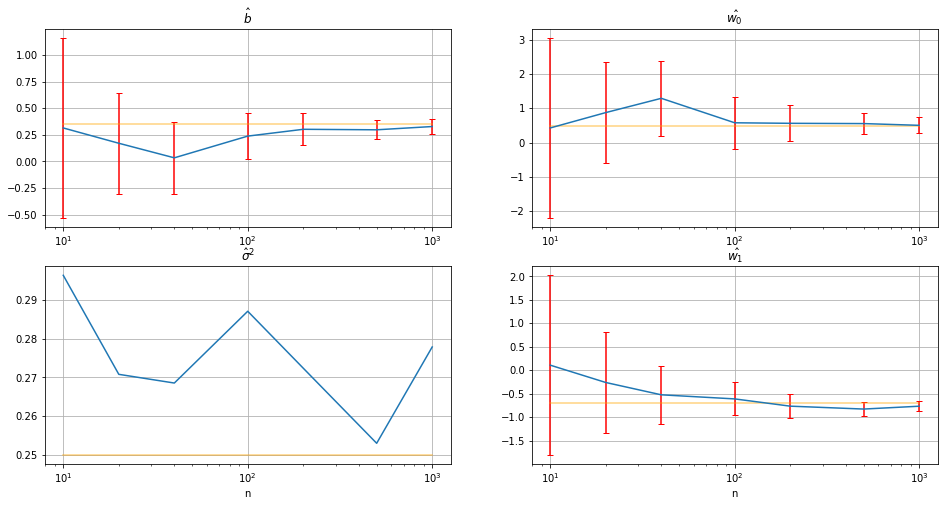

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={'xscale':'log'})

regressions = []
alpha = 0.05
for n in [10, 20, 40, 100, 200, 500, 1000]:
    x_m_n = x_m_1000[:n]
    y_n = y_1000[:n]
    thetaEst, confidence, noiseVar = linearRegressionLinearGaussian(x_m_n, y_n, alpha)
    regressions.append([n, 
                        thetaEst[0], thetaEst[1], thetaEst[2], 
                        confidence[0], confidence[1], confidence[2],
                        noiseVar])

dfSweepN2 = pd.DataFrame(regressions, columns=('n', 'b', 'w0','w1', 'bConf', 'w0Conf', 'w1Conf', 'noise var'))
plotToRef(dfSweepN2['n'], dfSweepN2['b'], bLin, ax[0,0], '$\hat{b}$', yErr=dfSweepN2['bConf'])
plotToRef(dfSweepN2['n'], dfSweepN2['noise var'], sigmaLin**2, ax[1,0], '$\hat{\sigma}^2$', xLabel='n')
plotToRef(dfSweepN2['n'], dfSweepN2['w0'], wLin[0], ax[0,1], '$\hat{w_0}$', yErr=dfSweepN2['w0Conf'])
plotToRef(dfSweepN2['n'], dfSweepN2['w1'], wLin[1], ax[1,1], '$\hat{w_1}$', yErr=dfSweepN2['w1Conf'], xLabel='n');

On above graphs, the error bars, in red, correspond to the confidence interval. For short dataset lengthS the confidence interval is tremendous. From 10 samples and over, the confidence interval is narrowing quickly.

The true value (orance line) should be within reach of the error bar, if not it means that the case is out of the 95% probability.

## Distributions with n = 5 and stochastic X values

A different set of experiments in which noise is drawn from the gaussian distribution, and X from the uniform distributions.

In [17]:
regressions = []
n = 5
for l in range(50000):
    # Draw a new batch
    x, yClean, y = generateBatchLinear(n)
    x_m = xWithIntercept(x)
    thetaEst = linearRegression(x_m, y)
    noiseMu, noiseVar = noiseEstimation(np.matmul(x_m, thetaEst), y, nFeatures)
    regressions.append([thetaEst[0], thetaEst[1], thetaEst[2], noiseMu, noiseVar])
    
df_5s = pd.DataFrame(regressions, columns=('b', 'w0','w1', 'noise mean', 'noise var'))

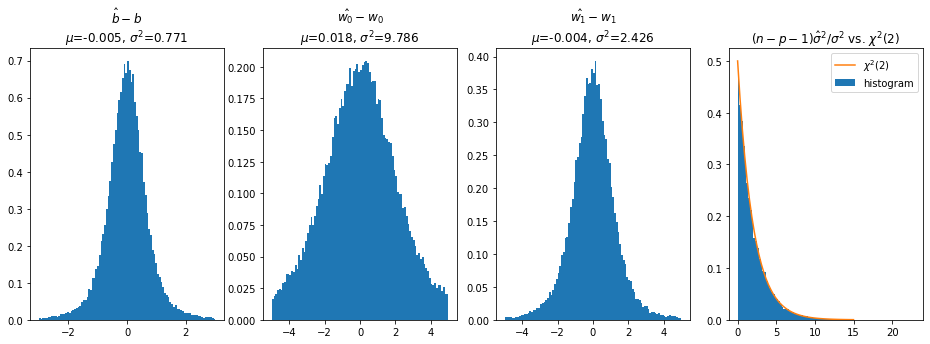

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
plotHistParams(df_5s['b']  - bLin,    '$\hat{b} - b$',     ax[0], [-3, 3])
plotHistParams(df_5s['w0'] - wLin[0], '$\hat{w_0} - w_0$', ax[1], [-5, 5])
plotHistParams(df_5s['w1'] - wLin[1], '$\hat{w_1} - w_1$', ax[2], [-5, 5])

dFree = n - nFeatures - 1
ax[3].hist(df_5s['noise var'] * dFree / sigmaLin**2, bins=100, density=True, label='histogram')
xx = np.linspace(0,15)
ax[3].plot(xx, stats.chi2(dFree).pdf(xx), label='$\chi^2(2)$')
ax[3].legend()
ax[3].set_title('$(n-p-1)\hat{\sigma}^2 / \sigma^2$ vs. $\chi^2(2)$');

On above graphs, compared to previous graphs, we observe that the shapes are similar but the variances are higher on $b, w_0, w_1$

Whereas the scaled noise variance is still matching the Chi-2 distribution

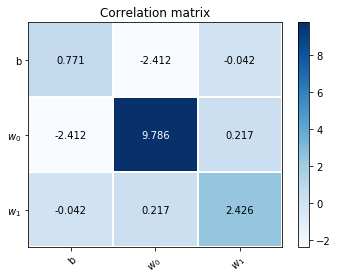

In [19]:
# Covariance of the intercept and weights
ThetaCov_5s = autoCovariance(df_5s[['b', 'w0', 'w1']].values)
plot_heat_map(ThetaCov_5s, ('b','$w_0$', '$w_1$'), title='Correlation matrix', fmt='.3f');

Globally the variance on the coefficients has increased, this reflects variability on fitting Y as a linear relation to X.